In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, morphology, img_as_float, measure, filters, transform, exposure, restoration

Contents:
* [Intro](#Intro)
* [Binary Morphology](#Binary-morphology)
    * Erosion / DIlation
    * Opening / Closing
    * Reconstruction 
* [Grayscale Morphology](#Grayscale-operations)
    * [Background noise](#Estimation-of-background-noise)

## Intro

In [ ]:
coins = data.coins() # 2^8 grey lvls -->  256 lvls --> 8-bit img. each pixel needs 1 byte of data to be represented.

The above image is of `int8` data type, i.e. it corresponds to an 8-bit image -- a total of 0-255 grey levels is possible. The number 255 needs a byte (8 bit) of data to be represented:

In [3]:
bin(255)

'0b11111111'

So one can calculate the size of the image in memory when its size is known:

In [4]:
size_in_mem = coins.size / 1e3 # in kb
print('Size in kb: {0}'.format(size_in_mem))

NameError: name 'coins' is not defined

Check what the actual size of the `coins` variable is, in memory:

In [5]:
%whos ndarray

No variables match your requested type.


Visualise the image, with a grey colorscale.

In [6]:
%matplotlib inline

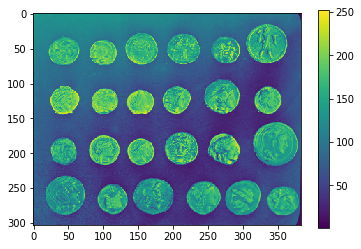

In [7]:
plt.imshow(coins)
plt.colorbar();

## Binary morphology

To look at this a binary image is obviously needed.

In [2]:
blobs = data.binary_blobs()
plt.imshow(blobs);plt.colorbar();

Any morphological operation requires a structuring element. The centre of the latter is placed at each image pixel centre, and a value is returned for each of these position. The value returned depends on the values of all image pixels that are contained in the structuring element. Depending on the morphological operation, different mathematical operations are carried out on the image pixels entailed by the structuring element in order to decide what the value of the output is. In the case of binary morphology, this is either a background or foreground pixel.

Because the example data is composed of blobs, a circular structuring element is most appropriate. The size of `blobs` is 512x512, so one can use a 10px radius disk:

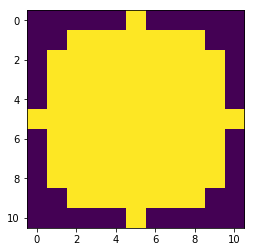

In [9]:
selem = morphology.selem.disk(5)
plt.imshow(selem);

### Erosion & Dilation

In [10]:
blobs_eroded = morphology.binary_erosion(blobs, selem=selem)
blobs_dilated = morphology.binary_dilation(blobs, selem=selem)
morpho_gradient = blobs_dilated ^ blobs_eroded  # logical XOR , dilation-erosion

Text(0.5,1,'Morphological Gradient')

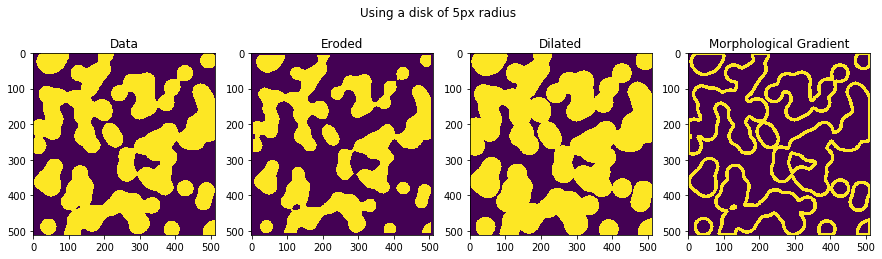

In [11]:
fig, axes = plt.subplots(1,4,figsize=(15,4))
ax = axes.ravel()
fig.suptitle('Using a disk of 5px radius')

ax[0].imshow(blobs)
ax[0].set_title('Data')

ax[1].imshow(blobs_eroded)
ax[1].set_title('Eroded')

ax[2].imshow(blobs_dilated)
ax[2].set_title('Dilated')

ax[3].imshow(morpho_gradient)
ax[3].set_title('Morphological Gradient')

### Opening & Closing

Opening / Closing can be used to remove spikes (noise)

In [12]:
radius = 20
selem = morphology.selem.disk(radius)
blobs_opened = morphology.binary_opening(blobs, selem=selem)
blobs_closed = morphology.binary_closing(blobs, selem=selem)

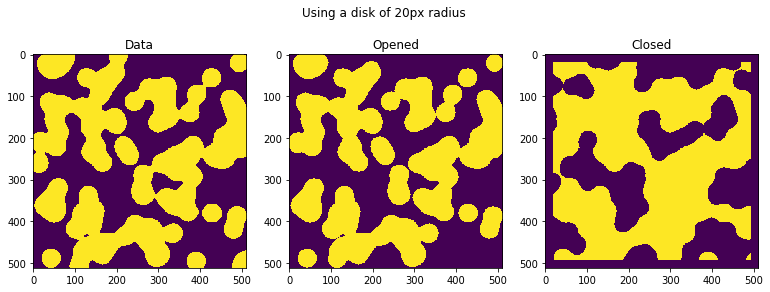

In [13]:
fig, axes = plt.subplots(1,3,figsize=(13,4.5))
ax = axes.ravel()
fig.suptitle('Using a disk of {0}px radius'.format(radius))

ax[0].imshow(blobs)
ax[0].set_title('Data')

ax[1].imshow(blobs_opened)
ax[1].set_title('Opened')

ax[2].imshow(blobs_closed)
ax[2].set_title('Closed');

### Reconstruction

My understading of the term *reconstruction* is that it corresponds to effectively re-creating the foreground objects of an image from the input image and optionally a set of a-priori assumptions. This corresponds to finding out which pixels belong to what, and is hence a synonim of labelling. Labelling decomposes an image into its *connected components* (objects).

The morphological reconstruction of an image A from a marker M (which is a subset of A) is defined as the union of all the connected components of image A that intersect marker M. Basically you start from the marker and find all of the connected components that intersect it.

Example of **grayscale** moprhological reconstruction (from the function's docs). One tries to extract the bright features of an image by subtracting a background image created by reconstruction

In [318]:
# Create sample img 
y, x = np.mgrid[:20:0.5, :20:0.5]
bumps = np.sin(x) + np.sin(y)
# Offset the (greyscale) intensity of the img
seed = bumps - 0.3
# Reconstruct
background = morphology.reconstruction(seed, bumps)
# Find peaks
hdome = bumps - background

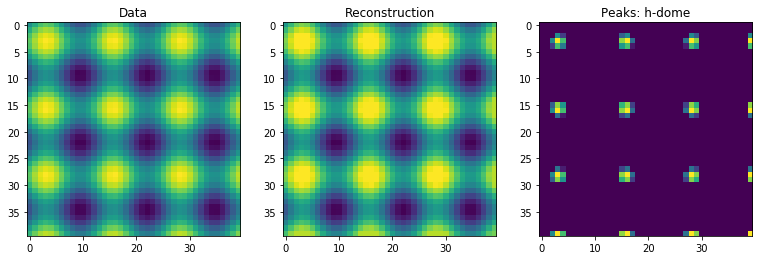

In [319]:
fig, axes = plt.subplots(1,3,figsize=(13,4.5))
ax = axes.ravel()
# fig.suptitle('Using a disk of {0}px radius'.format(radius))

ax[0].imshow(bumps)
ax[0].set_title('Data')

ax[1].imshow(background)
ax[1].set_title('Reconstruction')

ax[2].imshow(hdome)
ax[2].set_title('Peaks: h-dome');

The function `morphology.reconstruction` does not seem to work with binary images, since it requires the seed (marker) image to be less intense than the mask (to be reconstructed) image.

In [16]:
mask = blobs.astype(int) 
seed = np.zeros_like(mask) 
seed[200:250] = 1

test = morphology.reconstruction(seed,mask)

ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

## Grayscale operations

The threshold decomposition / stack reconstruction concepts described in the microscopy book are probably implemented in the grayscale morphological processing `skimage` functions and are hence of no direct concern here. Load some grayscale test data:

In [2]:
import lib.calc as c

# Load some test data
def load_kmap():
    sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
    rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
    s10 = c.read_kmap(sf, 10, rois_103)
    kmap = s10['roi2'][2].T[::-1].astype('float32')
    return kmap
plt.imshow(load_kmap())

Resize the image

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


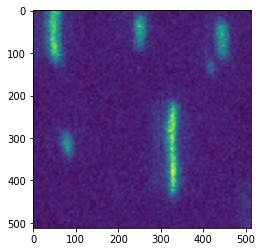

In [658]:
kmap /= kmap.max() # for the resize functin
rkmap = transform.resize(kmap, (512,512))
plt.imshow(rkmap)

The image is 32-bit and thus has 2^32 grey levels and is 40kb in size. See the effect of grayscale erosion / dilation:

In [104]:
radius = 2
selem = morphology.selem.disk(radius)
kmap_eroded = morphology.erosion(kmap, selem=selem)
kmap_dilated = morphology.dilation(kmap, selem=selem)
kmap_gradient = kmap_dilated - kmap_eroded

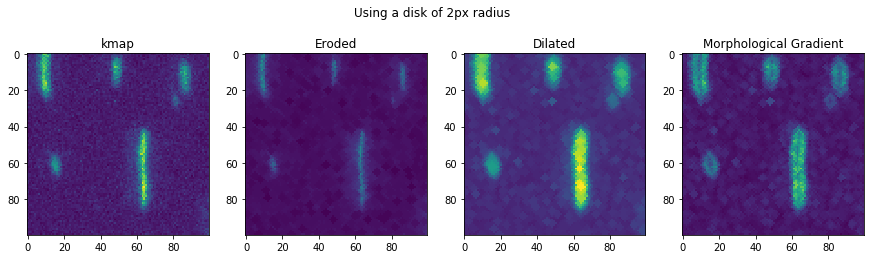

In [105]:
fig, axes = plt.subplots(1,4,figsize=(15,4))
ax = axes.ravel()
fig.suptitle('Using a disk of {0}px radius'.format(radius))

ax[0].imshow(kmap, vmin=kmap.min(), vmax=kmap.max())
ax[0].set_title('kmap')

ax[1].imshow(kmap_eroded, vmin=kmap.min(), vmax=kmap.max())
ax[1].set_title('Eroded')

ax[2].imshow(kmap_dilated, vmin=kmap.min(), vmax=kmap.max())
ax[2].set_title('Dilated')

ax[3].imshow(kmap_gradient, vmin=kmap.min(), vmax=kmap.max())
ax[3].set_title('Morphological Gradient');

I suppose the problem in the above is the noisy background which gets eroded / dilated too. The microscopy image processing book however suggests to first apply the stack filter (such as erosion or dilation) *and then* apply the threshold decomposition, instead of the opposite, which would of course solve the noise problem.

In [13]:
kmap = load_kmap()
r = 2
selem = morphology.selem.disk(r)
kmap_open = morphology.opening(kmap, selem=selem)
kmap_close = morphology.closing(kmap, selem=selem)

Text(0.5,1,'Closed')

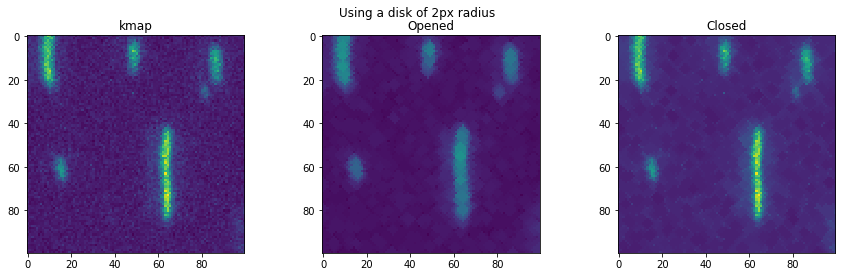

In [16]:
%matplotlib inline
fig, axes = plt.subplots(1,3,figsize=(15,4))
ax = axes.ravel()
fig.suptitle('Using a disk of {0}px radius'.format(r))

ax[0].imshow(kmap, vmin=kmap.min(), vmax=kmap.max())
ax[0].set_title('kmap')

ax[1].imshow(kmap_open, vmin=kmap.min(), vmax=kmap.max())
ax[1].set_title('Opened')

ax[2].imshow(kmap_close, vmin=kmap.min(), vmax=kmap.max())
ax[2].set_title('Closed')

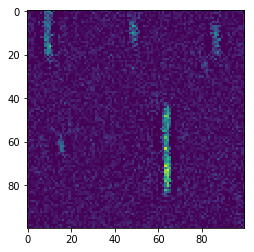

In [22]:
plt.imshow(kmap-kmap_open)

Opening and closing in succession can be used to remove additive and subtractive noise in the image. But perhaps it only works for binary images... The idea is to remove background pixels in the foreground and foreground pixels in the background.

Text(0.5,1,'Opened then closed')

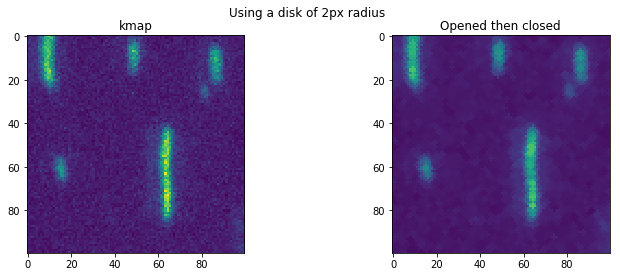

In [21]:
kmap_open_close = morphology.closing(morphology.opening(kmap))

fig, axes = plt.subplots(1,2,figsize=(12,4))
ax = axes.ravel()
fig.suptitle('Using a disk of {0}px radius'.format(radius))

ax[0].imshow(kmap, vmin=kmap.min(), vmax=kmap.max())
ax[0].set_title('kmap')

ax[1].imshow(kmap_open_close, vmin=kmap.min(), vmax=kmap.max())
ax[1].set_title('Opened then closed')

### Estimation of background noise


In [100]:
# Background data
background = kmap[:,20:40]
hist, bins_centre = exposure.histogram(background,nbins=31)
std = np.std(background)
mean = np.mean(background)
hist = hist/hist.max()  # normalise to make it a PDF

# Model
model = np.random.normal(mean,std,background.size)
h, b = exposure.histogram(model,nbins=50)
h = h/h.max()

In [102]:
# Assume gaussian and estdimate std dev on whole image
est_std = restoration.estimate_sigma(kmap)

print(est_std, std)

3.89670106984 3.82663


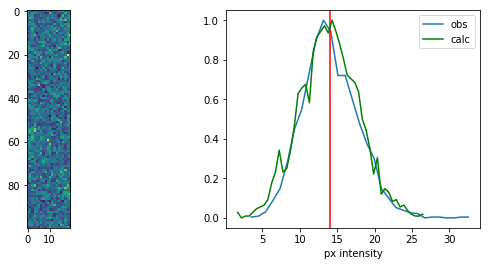

In [108]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax = ax.ravel()

ax[0].imshow(background)

ax[1].plot(bins_centre, hist, label='obs')
ax[1].set_xlabel('px intensity')
ax[1].axvline(mean,c='r')
ax[1].plot(b,h,c='g',label='calc')

plt.legend();

Looks gaussian to me! Or maybe Raileigh. System noise really should be estimated by a 'dark field' image. How can I obtain that with kmaps?

Additive noise does what it says. For example with the blob image:

In [128]:
blobs = img_as_float(blobs) 
noise = np.random.normal(1, 0.1, size=blobs.size)
noised_blobs = blobs + noise.reshape(blobs.shape) # just add them

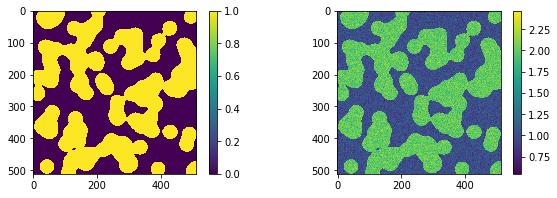

In [130]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

im = ax[0].imshow(blobs)
plt.colorbar(im,ax=ax[0])
im_noise = ax[1].imshow(noised_blobs)
plt.colorbar(im_noise,ax=ax[1])

Then try to denoise it.

In [131]:
selem = morphology.selem.disk(5)
noised_blobs /= noised_blobs.max()
blobs_geom = filters.rank.geometric_mean(noised_blobs, selem) # better than the arithmetic mean
blobs_med = filters.rank.median(noised_blobs, selem)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


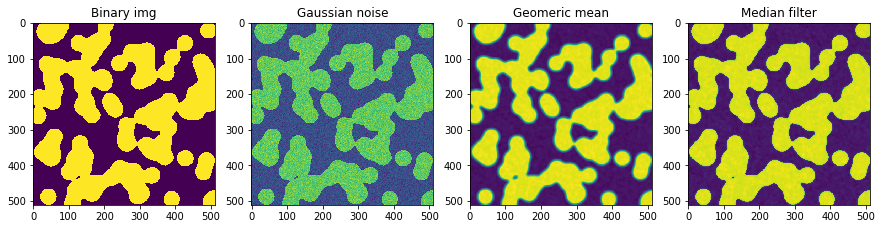

In [132]:
fig, ax = plt.subplots(1,4,figsize=(15,10))
ax = ax.ravel()

ax[0].imshow(blobs)
ax[0].set_title('Binary img')
ax[1].imshow(noised_blobs)
ax[1].set_title('Gaussian noise')
ax[2].imshow(blobs_geom)
ax[2].set_title('Geomeric mean')
ax[3].imshow(blobs_med)
ax[3].set_title('Median filter');

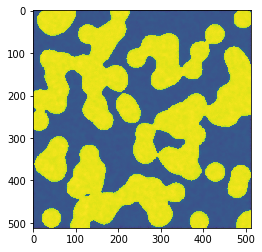

In [135]:
blobs_den = restoration.denoise_bilateral(noised_blobs,sigma_spatial=3,bins=10000,multichannel=False)
plt.imshow(blobs_den)

## Watershed

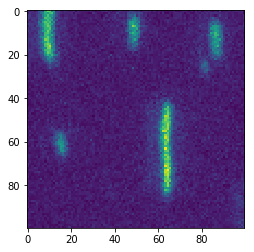

In [322]:
kmap = s10['roi2'][2].T[::-1].astype('float32')
plt.imshow(kmap)

### H-maxima

This corresponds to the reconstruction by dilation of *f(x,y)* subtracted by *h*. It is a connected-component filter that removes any object with height *<=h* and decreases the height of the remaining objects by *h*.

$$ \text{HMAX}_h(f) = R^\delta_f(f-h) $$

From the matlab docu: Morphological reconstruction can be thought of as repeated dilation of the marker image until the contour of the marker image fits under the mask image.
* two masks
* no selem, but only connectivity (actually python function accepts selem)
* repeats intel idempotence (image no longer changes with additional dilation)

Can use morphological reconstruction to find local maxima:

![test](https://fr.mathworks.com/help/images/morph5.gif)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


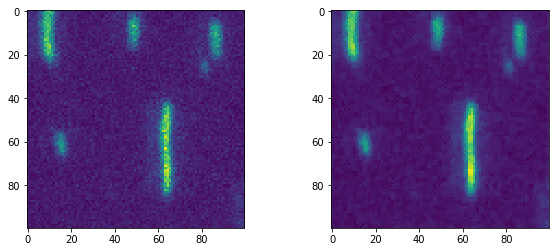

In [231]:
# Denoise
kmap = load_kmap() 
kmap /= kmap.max()
kmapd = filters.median(kmap, selem=morphology.selem.disk(1))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(kmap)
ax[1].imshow(kmapd)

In [396]:
sigma_est = restoration.estimate_sigma(kmap)
print(sigma_est)

3.89670106984


/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


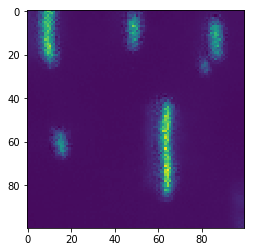

In [397]:
plt.imshow(restoration.denoise_nl_means(kmap,h=sigma_est))

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


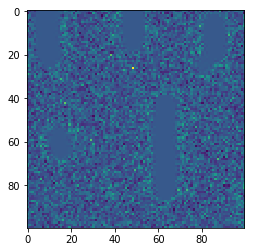

In [398]:
plt.imshow(kmap-restoration.denoise_nl_means(kmap,h=sigma_est))

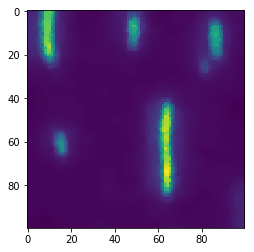

In [394]:
plt.imshow(restoration.denoise_tv_chambolle(kmap,weight=10))

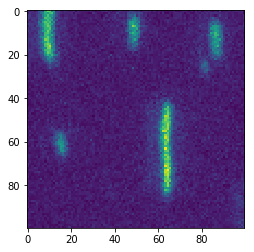

In [664]:
plt.imshow(kmapd)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


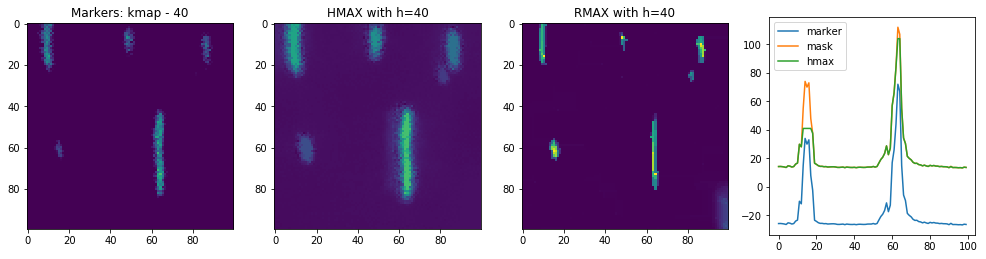

In [665]:
# Create a marker image by shifting the grayscale image by h
h = 40
# kmap = morphology.opening(load_kmap(), selem=morphology.selem.disk(1)
kmap = load_kmap()
sigma_est = restoration.estimate_sigma(kmap)
kmapd = restoration.denoise_nl_means(kmap,h=sigma_est)
# kmapd = restoration.denoise_tv_chambolle(kmap,weight=1)
# kmapd = morphology.opening(load_kmap(),selem=morphology.selem.disk(3))
marker = kmapd - h
# replace negative intensity values with zeroes - not needed but good for illustration
# marker = marker.flatten()
# for index, element in enumerate(marker):
#     if element < 0:
#         marker[index] = 0
# marker = marker.reshape(kmap.shape)
# The mask image is simply the image itself, that one wants the local max of
mask = kmapd
# reconstruct by dilation using 8-connectivity
hmax = morphology.reconstruction(marker, mask, method='dilation', selem=morphology.selem.disk(3))
# local max are original - reconstructed image (see picture above)
rmax = kmapd - hmax # hdome. defined as hmax in matlab, it seems
# rmax /= rmax.max()
rmax = morphology.closing(rmax, selem=morphology.selem.rectangle(8,12))
# rmax = morphology.closing(rmax, selem=morphology.selem.disk(10))


fig, ax = plt.subplots(1,4,figsize=(17,4))

ax[0].imshow(marker, vmin=kmapd.min(), vmax=kmapd.max()); ax[0].set_title('Markers: kmap - {0}'.format(h))
# ax[1].imshow(mask); ax[1].set_title('Mask')
ax[1].imshow(hmax, vmin=kmapd.min(), vmax=kmapd.max()); ax[1].set_title('HMAX with h={0}'.format(h))
ax[2].imshow(rmax); ax[2].set_title('RMAX with h={0}'.format(h));
yslice = 60
ax[3].plot(marker[yslice], label='marker')
ax[3].plot(mask[yslice], label='mask')
ax[3].plot(hmax[yslice], label='hmax')
# ax[3].plot(rmax[yslice], label='rmax')
plt.legend();

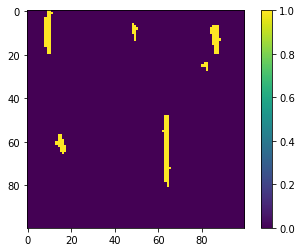

In [666]:
ots = filters.threshold_otsu(rmax, nbins=int(rmax.max()))
plt.imshow(rmax > ots)
plt.colorbar()

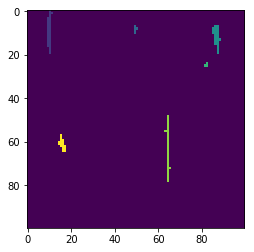

In [683]:
markers = rmax>ots
ts = morphology.binary_erosion(markers, selem=morphology.selem.rectangle(1,2))
labels, nlabels = morphology.label(ts, neighbors=4, return_num=True)
labels += 0
# plt.imshow(kmap)
# plt.imshow(markers, alpha=0.3)
plt.imshow(labels)

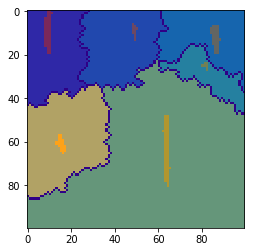

In [684]:
# use labeled markers as basin markers
wshed = morphology.watershed(-kmapd, labels, watershed_line=True)
plt.imshow(wshed)
plt.imshow(markers, cmap='bwr',alpha=0.3)

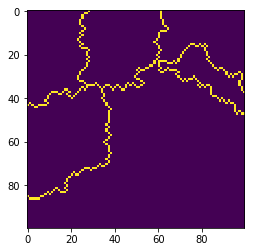

In [685]:
# use the lines as outer markers and assing max label value
lines = (wshed==0).astype('int8')
lines[wshed==0] = nlabels + 1
plt.imshow(lines)

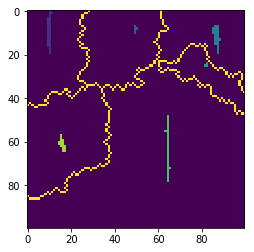

In [686]:
markers =  labels + lines
plt.imshow(markers)

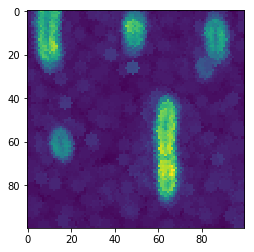

In [687]:
r = 3
mgrad = morphology.dilation(kmap,selem=morphology.selem.disk(r)) - morphology.erosion(kmap,selem=morphology.selem.disk(r))
plt.imshow(mgrad)

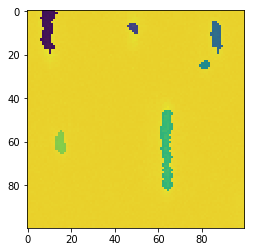

In [688]:
wshed2 = morphology.watershed(mgrad,markers,watershed_line=False)
plt.imshow(kmap)
plt.imshow(wshed2, alpha=0.9)

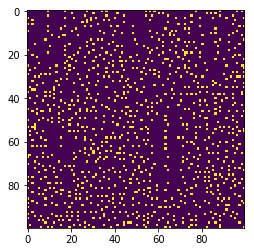

In [256]:
lmax = morphology.local_maxima(kmapd)
plt.imshow(lmax)

In [259]:
(lmax == rmax).all()

True

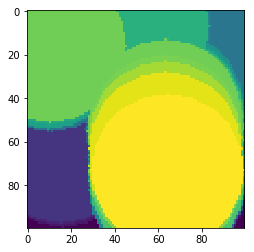

In [146]:
marker = morphology.dilation(marker, selem=morphology.selem.disk(15))
plt.imshow(marker)

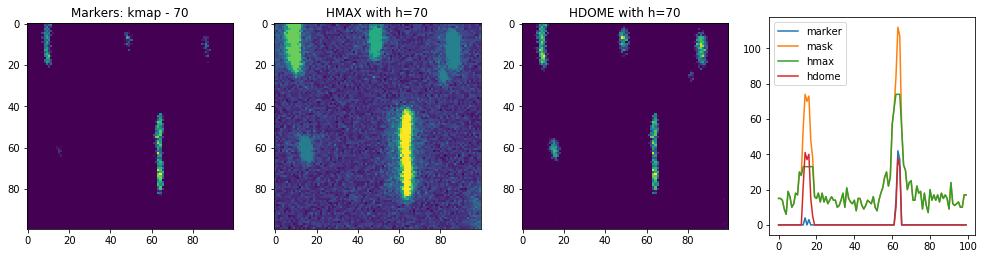

In [136]:
# Create a marker image by shifting the grayscale image by h
h = 70
# kmap = morphology.opening(load_kmap(), selem=morphology.selem.disk(1))
kmap = load_kmap()
marker = kmap - h
# replace negative intensity values with zeroes - not needed but good for illustration
marker = marker.flatten()
for index, element in enumerate(marker):
    if element < 0:
        marker[index] = 0
marker = marker.reshape(kmap.shape)
# The mask image is simply the image itself, that one wants the local max of
mask = kmap
# reconstruct by dilation using 8-connectivity
hmax = morphology.reconstruction(marker, mask, method='dilation', selem=morphology.selem.disk(20))
# local max are original - reconstructed image (see picture above)
hdome = kmap - hmax # hdome when h > 1

fig, ax = plt.subplots(1,4,figsize=(17,4))

ax[0].imshow(marker); ax[0].set_title('Markers: kmap - {0}'.format(h))
# ax[1].imshow(mask); ax[1].set_title('Mask')
ax[1].imshow(hmax); ax[1].set_title('HMAX with h={0}'.format(h))
ax[2].imshow(hdome); ax[2].set_title('HDOME with h={0}'.format(h));
yslice = 60
ax[3].plot(marker[yslice], label='marker')
ax[3].plot(mask[yslice], label='mask')
ax[3].plot(hmax[yslice], label='hmax')
ax[3].plot(hdome[yslice], label='hdome')
plt.legend();

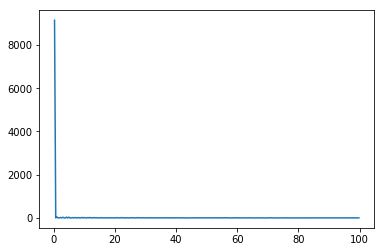

In [55]:
hist, binc = exposure.histogram(hdome)
plt.plot(binc, hist)

Also check this out: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html

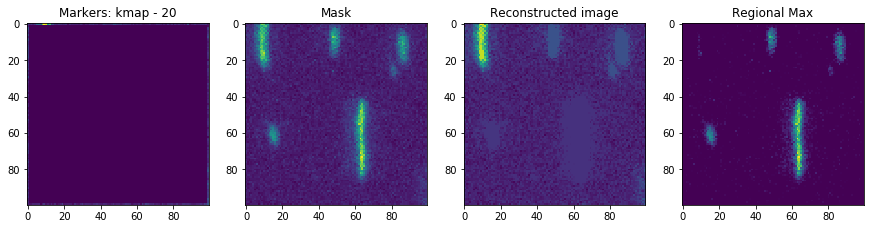

In [416]:
# Create a marker image by shifting the grayscale image by h
kmap = load_kmap()
marker = kmap.copy()
marker[1:-1, 1:-1] = kmap.min()
# The mask image is simply the image itself, that one wants the local max of
mask = kmap
# reconstruct by dilation using 8-connectivity
reconstructed = morphology.reconstruction(marker, mask, method='dilation', selem=morphology.selem.disk(3))
# local max are original - reconstructed image (see picture above)
hmax = mask - reconstructed

fig, ax = plt.subplots(1,4,figsize=(15,4))

ax[0].imshow(marker); ax[0].set_title('Markers: kmap - {0}'.format(h))
ax[1].imshow(mask); ax[1].set_title('Mask')
ax[2].imshow(reconstructed); ax[2].set_title('Reconstructed image')
ax[3].imshow(hmax); ax[3].set_title('Regional Max'.format(h));

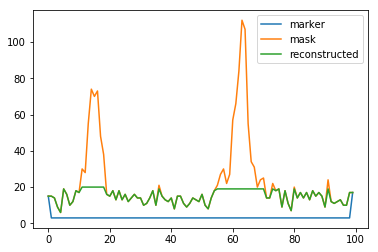

In [418]:
yslice = 60
plt.plot(marker[yslice], label='marker')
plt.plot(mask[yslice], label='mask')
plt.plot(reconstructed[yslice], label='reconstructed')
plt.legend();

The HMAX operation I am trying to achieve is also directly implemented in python, although it returns a mask which seems to have only one-pixel wide regions:

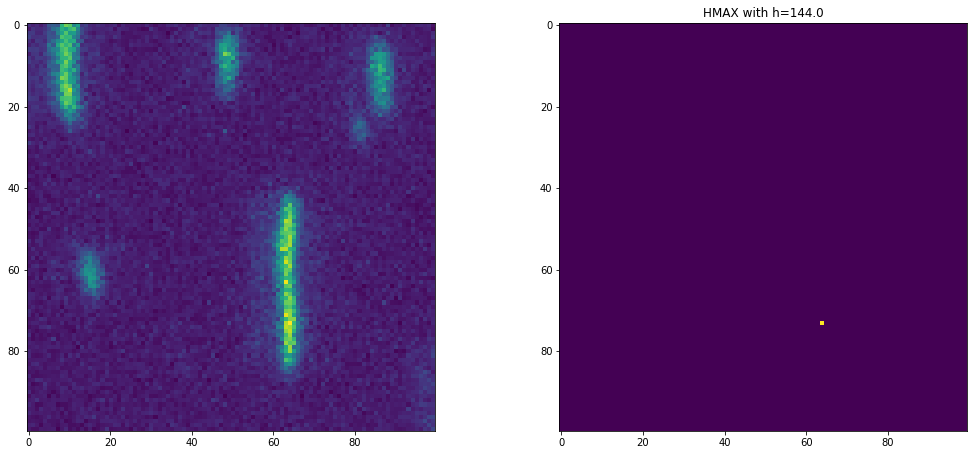

In [33]:
h = kmap.max()
hmax = morphology.h_maxima(kmap, h)

fig, ax = plt.subplots(1,2,figsize=(7*2.5,3*2.5))

ax[0].imshow(kmap)
ax[1].imshow(hmax); ax[1].set_title('HMAX with h={0}'.format(h));

In [169]:
synth = np.random.rand?

In [281]:
synth = np.zeros((100,100))
synth[50,60] = 100
synth[50,20] = 200
synth = filters.gaussian(synth, sigma=10)

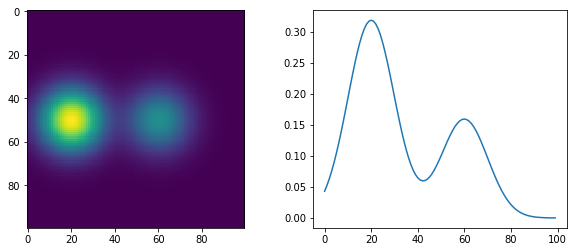

In [282]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(synth)
ax[1].plot(synth[50])

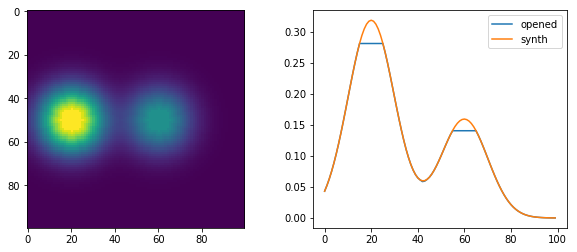

In [321]:
opened = morphology.opening(synth, selem=morphology.selem.disk(5))
# opened = synth
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(opened)
ax[1].plot(opened[50], label='opened')
ax[1].plot(synth[50], label='synth')
plt.legend()

In [322]:
mask = opened - 0.1
hmax = morphology.reconstruction(mask, opened, selem=morphology.selem.disk(5))
rmax = opened - hmax

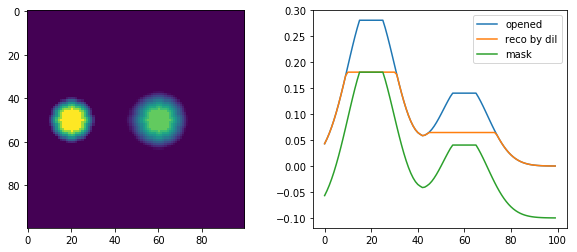

In [323]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].imshow(rmax)
ax[1].plot(opened[50], label='opened')
ax[1].plot(hmax[50], label='reco by dil')
ax[1].plot(mask[50], label='mask')
plt.legend()

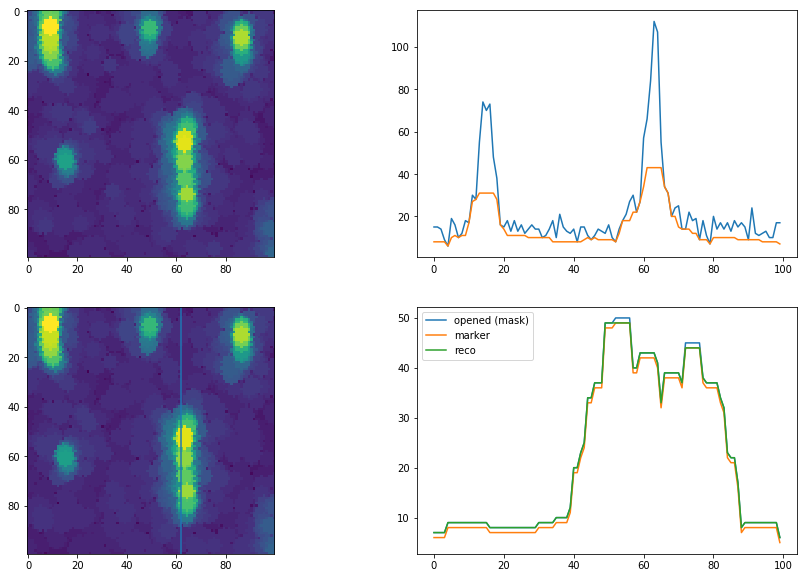

In [342]:
kmap = load_kmap()
kmap_open = morphology.opening(kmap, selem=morphology.selem.disk(3))
marker = kmap_open - 1
hmax = morphology.reconstruction(marker, kmap_open, selem=morphology.selem.square(3))
rmax = kmap_open - hmax

fig, axes = plt.subplots(2,2,figsize=(15,10))
ax = axes.ravel()

ax[0].imshow(kmap_open)
ax[1].plot(kmap[60])
ax[1].plot(kmap_open[60])
ax[2].imshow(hmax)
ax[2].axvline(62)
ax[3].plot(kmap_open[:,62], label='opened (mask)')
ax[3].plot(marker[:,62], label='marker')
ax[3].plot(hmax[:,62], label='reco')
plt.legend();

Sudden variations of intensity (=noise) are too close even for the smallest structuring element. So not all regional max are tracked. Must use hdome for markers.

In [345]:
kmap = load_kmap()
kmap_open = morphology.opening(kmap, selem=morphology.selem.disk(3))

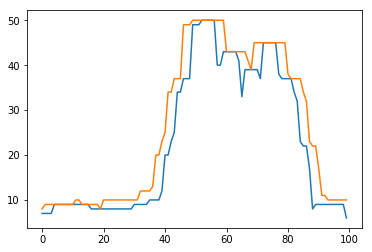

In [348]:
dilate_open = morphology.dilation(kmap_open, selem=morphology.selem.disk(3))
plt.plot(kmap_open[:,62])
plt.plot(dilate_open[:,62])

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


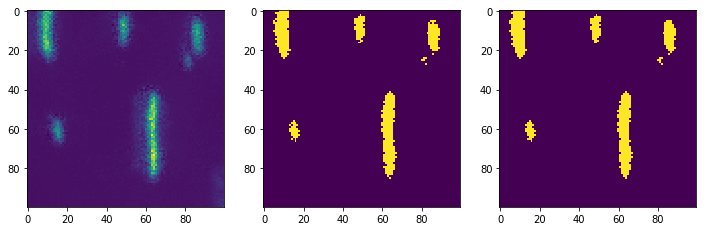

In [458]:
# load
kmap = load_kmap()
# est noise (assume gaussian)
est_sigma = restoration.estimate_sigma(kmap)
# denoise
kmapd = restoration.denoise_nl_means(kmap, h=0.8*est_sigma)
# treshold
t = filters.threshold_otsu(kmapd)
kmapdt = kmap > t
# erode to make markers
markers = morphology.closing(kmapdt, selem=morphology.selem.disk(1))
# markers = morphology.erosion(markers, selem=morphology.selem.disk(1))


fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(kmapd)
ax[1].imshow(kmapdt)
ax[2].imshow(markers)

In [13]:
kmap = load_kmap() / load_kmap().max()

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


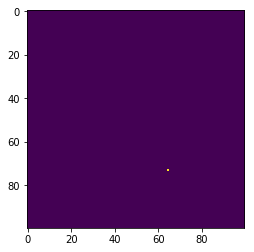

In [25]:
lmax = filters.rank.maximum(kmap, selem=morphology.selem.disk(10))
lmax = lmax / lmax.max()
plt.imshow(lmax==kmap)